# Learning Analytics based on Skills

We will be using a number of diiferent algorithms on the given data to try and get some information from it. We will be focusing on the 'Job_Description' column of the dataset as that is where most of the content lies. Here is a roadmap of all the different methods/ algorithms that we will attempt to tackle in this notebook.

1) Exploring the data to get an idea of what we have on our hands.

2) Basic text searching to get some low level features like 'Big Data', 'AI', etc. from the job description, much like how it has already been demonstrated for 'Excel', 'Hadoop', etc.

3) Getting high level technical and non-technical features by identifying n-grams from the job descriptions.

4) Clustering these high level features to get simple clusters that can tell us the requirements from each job (see point 6). We will also name the clusters so they have some meaning.

5) Using topic modelling to get an idea of how documents are distributed over different topics and topics over different terms.

6) Using the vector space model to identify the similarities between each document and the clusters. We will use TFIDF vectors for this purpose.

7) Using Self Organising Maps to visualise all the companies on the map. This will give us a good idea of which companies are closer to each other. 

8) We build a text classifier that can predict the technical and non-technical cluster for any future job posting purely from its job description.

9) Finally, we will design a curriculum for the course 'Data Analytics and AI' using all the knowledge that we have just gained.

### Install and import libraries

In [0]:
!pip install bs4
!pip install wordcloud
!pip install gensim
!pip install minisom
!pip install pyLDAvis

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bs4
import re
from string import punctuation
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import gc
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text
import nltk.stem
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
import gensim
import pyLDAvis
import pyLDAvis.gensim
import pickle 
from sklearn.metrics.pairwise import cosine_similarity
from minisom import MiniSom
import operator
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
nltk.download('punkt')
nltk.download('stopwords')

### Define job title and geographic location

Search Indeed.ca web-site for "Data Scientist" job vacancies at the specified geographic location.

In [0]:
#jobtitle = str(input("Please enter the job title: "))
jobtitle = 'data scientist'
#location = str(input("Please enter the job location:"))
location = 'Toronto'
query1=jobtitle.replace(' ','+')
query2=location.replace(' ','+')
urlorig='https://www.indeed.ca/jobs?q='+query1+'&l='+query2+'&start='
urlorig

'https://www.indeed.ca/jobs?q=data+scientist&l=Toronto&start='

### Create list of job vacancies

Extract knowledge of technologies (Python, Excel, R, Matlab, Hadoop, Spark, etc.)

In [0]:
# Empty list for job_title, company_name, location, job_description, job skills
titles = []
company_names = []
location_names = []
job_descriptions = []
job_ids = []
skills = {}
skills['Python'] = []
skills['R '] = []
skills['Matlab'] = []
skills['Excel'] = []
skills['SAS'] = []
skills['SQL'] = []
skills['SPSS'] = []
skills['Hadoop'] = []
skills['Spark'] = []

# Loop over 1000 vacancies (20 at each page)
for i in range(0,1000,20):
    
    # html parsing Indeed job portal page 
    my_url = urlorig+str(i)
    uClient = uReq(my_url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html,'html.parser')
    
    # extract job_title
    jobs = page_soup.findAll("div", class_="row" )
    for job in jobs:
        try:
            titles.append(job.a["title"])
        except:
            titles.append("NA")
        
    # extract company_name
    companies = page_soup.findAll("span", class_="company" )
    for company in companies:
        try:
            company_names.append(company.text.strip())
        except:
            company_names.append("NA")
    
    # extract location       
    locations = page_soup.findAll( class_="location")
    for location in locations:
        try:
            location_names.append(location.text)
        except:
            location_names.append("NA")
    
    # extract job_description 
    links = page_soup.findAll("div", class_ = "row")   
    for link in links:
        
        Jb = uReq("https://www.indeed.ca" + link.a["href"])
        try:
            res_id = re.search('clk\?jk=(.*)&fccid', link.a["href"])
            job_ids.append(res_id.group(1))
        except:
            job_ids.append("")
        Jb_html = Jb.read()
        Jb.close()
        Jb_soup = soup(Jb_html, "html.parser")
        
        job_description = Jb_soup.findAll("div", class_= "jobsearch-JobComponent-description")
        cleantext = soup(str(job_description), 'html.parser').text
        try:
            job_descriptions.append(cleantext)  
        except:
            job_descriptions.append("NA")  
            
        if("excel" in cleantext.lower()):
            skills['Excel'].append('1')
        else:
            skills['Excel'].append('0')
            
        if("python" in cleantext.lower()):
            skills['Python'].append('1')
        else:
            skills['Python'].append('0')
            
        if("R " in cleantext):
            skills['R '].append('1')
        else:
            skills['R '].append('0')
        
        if("matlab" in cleantext.lower()):
            skills['Matlab'].append('1')
        else:
            skills['Matlab'].append('0')
        
        if("sas" in cleantext.lower()):
            skills['SAS'].append('1')
        else:
            skills['SAS'].append('0')
            
        if("sql" in cleantext.lower()):
            skills['SQL'].append('1')
        else:
            skills['SQL'].append('0')
            
        if("spss" in cleantext.lower()):
            skills['SPSS'].append('1')
        else:
            skills['SPSS'].append('0')
            
        if("hadoop" in cleantext.lower()):
            skills['Hadoop'].append('1')
        else:
            skills['Hadoop'].append('0')
        
        if("spark" in cleantext.lower()):
            skills['Spark'].append('1')
        else:
            skills['Spark'].append('0')

### Create dataframe with job vacancies and save it to csv file

In [0]:
d = {'Job_ID':job_ids,'Job_Title':titles,'Company_Name':company_names,'Location':location_names,'Job_Description':job_descriptions}
df1 = pd.DataFrame(d)
df2 = pd.DataFrame(skills)
frames = [df1, df2]
results = pd.concat(frames, axis = 1)
results.head()

Company_Name                                    Job_Description  \
0         Indeed Prime                                                 []   
1  Samsung Electronics  [Position Summary\n\nWe are looking for a Data...   
2       Loblaw Digital  [Loblaw Digital is the team responsible for bu...   
3          CPQi Canada  [Description: As the leading capital markets s...   
4  BMO Financial Group  [We are looking for a talented individual to j...   

             Job_ID                         Job_Title         Location Excel  \
0                                      Data Scientist      Toronto, ON     0   
1                             Manager, Data Scientist  Mississauga, ON     0   
2                                      Data Scientist      Toronto, ON     0   
3                    Data Scientist - Capital Markets      Toronto, ON     0   
4  7dc582035711b632            Data Scientist/Analyst      Toronto, ON     0   

  Hadoop Matlab Python R  SAS SPSS SQL Spark  
0      0      0      0  0   0    0   0     0  
1      0      0      1  0   0    0   1     1  
2      1      0      1  0   0    0   1     0  
3      1      0      0  0   0    0   1     1  
4      0      0      0  0   1    0   1     0

In [0]:
results.tail()

Company_Name  \
997                    ROSS Recruitment   
998                                 ADP   
999                               Aviva   
1000  Sunnybrook Health Sciences Centre   
1001      Premium Retail Services, Inc.   

                                        Job_Description            Job_ID  \
997   [ContractOur client is a premier brand in medi...  67f4ffe25243202a   
998   [Senior Java API Application Developer - ( Bac...  60e6097a5cc3316e   
999   [At Aviva, we are on a mission to rethink how ...  f7cf69293b76e27d   
1000  [CLASSIFICATION: SRI - grant funded (1 year re...  61a3242263a24742   
1001  [POSITION OPEN: Samsung Analytics Manager (Can...  aafe7b55dc0c84a9   

                                              Job_Title         Location  \
997      C# WPF Software Dev Contract 1000 Referral Fee      Concord, ON   
998   Senior Java API Application Developer - ( Back...  Mississauga, ON   
999   Senior Actuarial Manager, Personal Insurance M...      Markham, ON   
1000         Postdoctoral research fellow - MRI Physics      Toronto, ON   
1001                          Samsung Analytics Manager  Mississauga, ON   

     Excel Hadoop Matlab Python R  SAS SPSS SQL Spark  
997      0      0      0      0  0   0    0   0     0  
998      1      0      0      0  0   1    0   1     0  
999      1      0      0      1  0   0    0   0     0  
1000     1      0      0      0  1   0    0   0     0  
1001     1      0      0      0  1   1    0   1     0

In [0]:
results.to_csv('Indeed_job_vacancies.csv')

### Plot percent of vacancies requiring knowledge of technology stacks

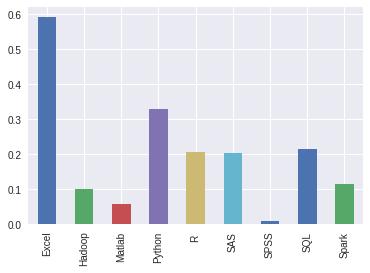

In [0]:
%matplotlib inline
df2.apply(pd.to_numeric).mean().plot(kind='bar')

###1) Exploring the data to get an idea of what we have on our hands

To get an idea of the words in our data, let us plot a word cloud and a word-frequency chart as well.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


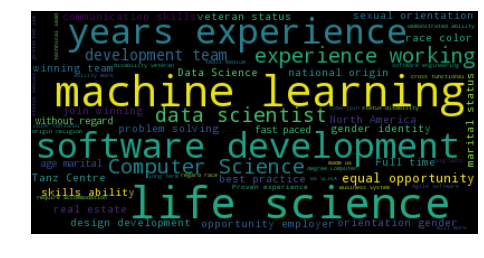

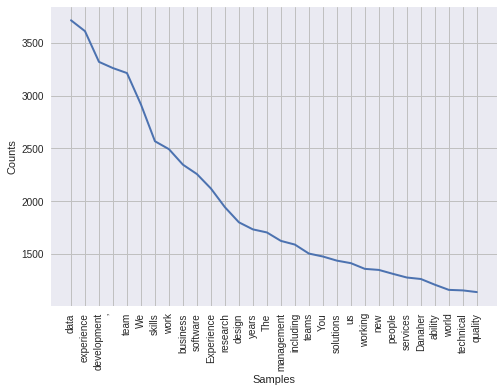

In [0]:
def word_cloud(df, feature_name):
    text = ''
    for index, row in df.iterrows():
        text += row[feature_name]
        text += ' '
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.close(1)
    
def freq_graph(df, feature_name):
  text = ''
  for index, row in df.iterrows():
    text += row[feature_name]
    text += ' '
  tokens = nltk.tokenize.word_tokenize(text)
  stops = list(set(stopwords.words('english')))
  tokens_minus_stop = [i for i in tokens if i not in stops and i not in punctuation]
  fd = nltk.FreqDist(tokens_minus_stop)
  fd.plot(30,cumulative=False)
    
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv')
word_cloud(df, 'Job_Description')
freq_graph(df, 'Job_Description')

From the word cloud, we identify some important words such as 'machine learning', 'software development' and 'data scientist' straight away. From the frequency plot, we identify key terms such as 'data', 'experience', 'management', etc.

###2) Now let us move on to some basic text searching to enhance the given file by adding a few more skills. 
We choose to add Machine Learning, Deep learning, Artificial Intelligence, Databases, Big Data and Software Development based on the word cloud and the frequency chart.

In [0]:
def basic_text_search():
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv', encoding = 'ISO-8859-1')
    more_skills = {'Machine Learning':[], 'Deep Learning':[], 'Big Data':[], 'Artificial Intelligence':[], 'Databases':[], 'Software Development': []}
    for index, row in df.iterrows():
        text = row['Job_Description']
        text = text.lower()
        if(('ml' in text) or ('machine learning' in text)):
            more_skills['Machine Learning'].append(1)
        else:
            more_skills['Machine Learning'].append(0)
        if('deep learning' in text):
            more_skills['Deep Learning'].append(1)
        else:
            more_skills['Deep Learning'].append(0)
        if('big data' in text):
            more_skills['Big Data'].append(1)
        else:
            more_skills['Big Data'].append(0)
        if(('artificial intelligence' in text) or ('ai' in text)):
            more_skills['Artificial Intelligence'].append(1)
        else:
            more_skills['Artificial Intelligence'].append(0)
        if('database' in text):
            more_skills['Databases'].append(1)
        else:
            more_skills['Databases'].append(0)
        if('software' in text):
            more_skills['Software Development'].append(1)
        else:
            more_skills['Software Development'].append(0)
    more_skills = pd.DataFrame(more_skills)
    results = pd.concat([df, more_skills], axis = 1)
    return results
    
results = basic_text_search()
results.head()

Unnamed: 0         Company_Name  \
0           0         Indeed Prime   
1           1  Samsung Electronics   
2           2       Loblaw Digital   
3           3          CPQi Canada   
4           4  BMO Financial Group   

                                     Job_Description            Job_ID  \
0                                                 []               NaN   
1  [Position Summary\n\nWe are looking for a Data...               NaN   
2  [Loblaw Digital is the team responsible for bu...               NaN   
3  [Description: As the leading capital markets s...               NaN   
4  [We are looking for a talented individual to j...  7dc582035711b632   

                          Job_Title         Location  Excel  Hadoop  Matlab  \
0                    Data Scientist      Toronto, ON      0       0       0   
1           Manager, Data Scientist  Mississauga, ON      0       0       0   
2                    Data Scientist      Toronto, ON      0       1       0   
3  Data Scientist - Capital Markets      Toronto, ON      0       1       0   
4            Data Scientist/Analyst      Toronto, ON      0       0       0   

   Python          ...           SAS  SPSS  SQL  Spark  \
0       0          ...             0     0    0      0   
1       1          ...             0     0    1      1   
2       1          ...             0     0    1      0   
3       0          ...             0     0    1      1   
4       0          ...             1     0    1      0   

   Artificial Intelligence  Big Data  Databases  Deep Learning  \
0                        0         0          0              0   
1                        1         1          0              0   
2                        1         1          0              0   
3                        1         1          0              0   
4                        1         0          1              0   

   Machine Learning  Software Development  
0                 0                     0  
1                 1                     0  
2                 1                     1  
3                 1                     0  
4                 0                     0  

[5 rows x 21 columns]

In [0]:
results.tail()

Unnamed: 0                       Company_Name  \
997          997                   ROSS Recruitment   
998          998                                ADP   
999          999                              Aviva   
1000        1000  Sunnybrook Health Sciences Centre   
1001        1001      Premium Retail Services, Inc.   

                                        Job_Description            Job_ID  \
997   [ContractOur client is a premier brand in medi...  67f4ffe25243202a   
998   [Senior Java API Application Developer - ( Bac...  60e6097a5cc3316e   
999   [At Aviva, we are on a mission to rethink how ...  f7cf69293b76e27d   
1000  [CLASSIFICATION: SRI - grant funded (1 year re...  61a3242263a24742   
1001  [POSITION OPEN: Samsung Analytics Manager (Can...  aafe7b55dc0c84a9   

                                              Job_Title         Location  \
997      C# WPF Software Dev Contract 1000 Referral Fee      Concord, ON   
998   Senior Java API Application Developer - ( Back...  Mississauga, ON   
999   Senior Actuarial Manager, Personal Insurance M...      Markham, ON   
1000         Postdoctoral research fellow - MRI Physics      Toronto, ON   
1001                          Samsung Analytics Manager  Mississauga, ON   

      Excel  Hadoop  Matlab  Python          ...           SAS  SPSS  SQL  \
997       0       0       0       0          ...             0     0    0   
998       1       0       0       0          ...             1     0    1   
999       1       0       0       1          ...             0     0    0   
1000      1       0       0       0          ...             0     0    0   
1001      1       0       0       0          ...             1     0    1   

      Spark  Artificial Intelligence  Big Data  Databases  Deep Learning  \
997       0                        1         0          0              0   
998       0                        1         0          0              0   
999       0                        1         0          0              0   
1000      0                        1         0          0              0   
1001      0                        1         0          0              0   

      Machine Learning  Software Development  
997                  0                     1  
998                  1                     1  
999                  0                     0  
1000                 0                     0  
1001                 0                     0  

[5 rows x 21 columns]

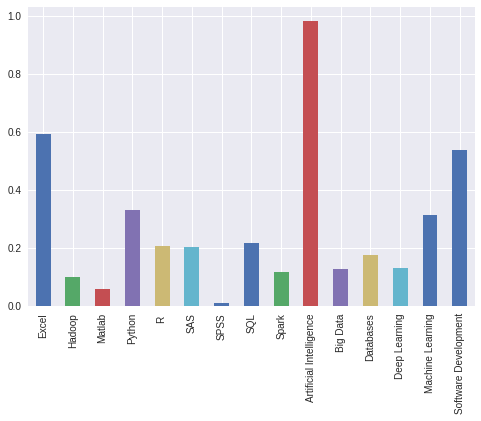

In [0]:
results.iloc[:,6:].apply(pd.to_numeric).mean().plot(kind='bar')

The graph gives an idea of the skills that are in demand from the companies. From the graph, it looks like Artificial Intelligence, Excel and Software Engineering are the leaders in terms of number of hits. In fact nearly all the companies require AI skills while less that 20% expect Databases skills.
We also note that Python is more popular than R and SAS is more popular than SPSS.

In [0]:
results.to_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies_more_skills.csv', encoding = 'utf-8')

###3) Get some more high level features from the data by looking for more meaningful n-grams from the job descriptions. 
We do this by looking for some particular keywords for both technical and non-technical skills. We also get a score for each feature that increases with the frequency of occurence of the feature. We start with the non-technical skills.

In [0]:
def non_tech_skills_from_text(postings, bigram_weight = 2, trigram_weight = 3, ngram_range = [2,4], stop_words = None):
  tv=CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, encoding='utf8')
  tv.fit(postings)
  posting_vec = tv.transform(postings)
  feats = tv.get_feature_names()
  counts = np.squeeze(np.asarray(posting_vec.sum(axis=0)))
  feat_scores = {}
  dictionary = {'feature':[], 'score':[],'count':[]}
  for feat, count  in zip(feats, counts):
      ngram_score = 1
      if not(feat.endswith('skill') 
          or feat.endswith('skills')
          or feat.startswith('perform') 
          or feat.startswith('deliver')
          or feat.startswith('ability')
          or feat.startswith('avail')
          or feat.endswith('experience')
          or feat.startswith('demonstrate')
          or 'knowledge' in feat 
          or 'educat' in feat
          or 'domain' in feat
          or 'expert' in feat
          or 'leader' in feat
          or 'manage' in feat
          or 'consult' in feat
          or 'communic' in feat
          or 'personal' in feat):
            continue
      if len(feat.split())>1:
          ngram_score = bigram_weight
      if len(feat.split())>2:
          ngram_score = trigram_weight
      if len(feat.split())>3:
          ngram_score = 4
      score = count**ngram_score
      if score > 0:
          feat_scores[feat] =  score
          dictionary['feature'] += [feat]
          dictionary['score'] += [score]
          dictionary['count'] += [count]
  return pd.DataFrame(dictionary)


df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv', encoding = 'ISO-8859-1') 
score_features = non_tech_skills_from_text(df['Job_Description'].values)
score_features.sort_values('score', ascending=False, inplace=True)
score_features['norm_score'] = score_features['score']/score_features.score.max()
score_features.head(20)

count                           feature      score  norm_score
21496    141          they face our leadership  395254161    1.000000
2354     141               are leaders in some  395254161    1.000000
12074    141                leaders in some of  395254161    1.000000
11246    141            knowledge for life our  395254161    1.000000
11928    141              leader come join our  395254161    1.000000
19254    141        science knowledge for life  395254161    1.000000
22207    141            us the industry leader  395254161    1.000000
21279    141          the industry leader come  395254161    1.000000
12267    141               leadership in lc ms  395254161    1.000000
10437    141         industry leader come join  395254161    1.000000
2183     141     answers for science knowledge  395254161    1.000000
9091     141            face our leadership in  395254161    1.000000
5654     141       deliver answers for science  395254161    1.000000
9373     141         for science knowledge for  395254161    1.000000
15989    141              our leadership in lc  395254161    1.000000
3546     141          class brands are leaders  395254161    1.000000
3087     141             brands are leaders in  395254161    1.000000
15691    134     or equivalent work experience  322417936    0.815723
2156     133  and written communication skills  312900721    0.791644
22806    133          with years of experience  312900721    0.791644

The non-technical features with the maximum scores are displayed above. 

In [0]:
score_features.to_csv('/content/drive/My Drive/Colab Notebooks/nt_tags_generated.csv', encoding = 'utf-8')
score_features.sort_values('count',ascending=False)[['feature']].to_csv('/content/drive/My Drive/Colab Notebooks/candidate_nt_features.tsv', encoding='utf8', index=False, sep='\t')

And now for the technical skills as well

In [0]:
def tech_skills_from_text(postings, bigram_weight = 2, trigram_weight = 3, ngram_range = [2,4], stop_words = None):
  tv=CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, encoding='utf8')
  tv.fit(postings)
  posting_vec = tv.transform(postings)
  feats = tv.get_feature_names()
  counts = np.squeeze(np.asarray(posting_vec.sum(axis=0)))
  feat_scores = {}
  dictionary = {'feature':[], 'score':[],'count':[]}
  for feat, count  in zip(feats, counts):
      ngram_score = 1
      if not((feat.endswith('skill') 
          or feat.endswith('skills')) 
          or (feat.startswith('machine') 
          or feat.startswith('big')
          or feat.startswith('data')
          or feat.endswith('science')
          or feat.startswith('computer')
          or feat.startswith('artificial')
          or 'deep learning' in feat
          or 'knowledge' in feat
          or 'design' in feat 
          or 'educat' in feat
          or 'engineer' in feat
          or 'intelligence' in feat
          or 'software' in feat
          or 'develop' in feat
          or 'hadoop' in feat
          or 'spark' in feat
          or 'sas' in feat
          or 'spss' in feat
          or 'matlab' in feat
          or 'sql' in feat
          or 'excel ' in feat)):
            continue
      if len(feat.split())>1:
          ngram_score = bigram_weight
      if len(feat.split())>2:
          ngram_score = trigram_weight
      if len(feat.split())>3:
          ngram_score = 4
      score = count**ngram_score
      if score > 0:
          feat_scores[feat] =  score
          dictionary['feature'] += [feat]
          dictionary['score'] += [score]
          dictionary['count'] += [count]
  return pd.DataFrame(dictionary)


score_features = tech_skills_from_text(df['Job_Description'].values)
score_features.sort_values('score', ascending=False, inplace=True)
score_features['norm_score'] = score_features['score']/score_features.score.max()
score_features.head(10)

count                        feature       score  norm_score
9555     286     degree in computer science  6690585616    1.000000
16163    164    experience in designing and   723394816    0.108121
16947    141      for science knowledge for   395254161    0.059076
1928     141  answers for science knowledge   395254161    0.059076
9573     141    deliver answers for science   395254161    0.059076
26162    141     science knowledge for life   395254161    0.059076
19562    141         knowledge for life our   395254161    0.059076
4937     141      danaher is global science   395254161    0.059076
9759     134      design and development of   322417936    0.048190
29704    133   the research and development   312900721    0.046767

The technical features with maximum scores are displayed above. 

In [0]:
score_features.to_csv('/content/drive/My Drive/Colab Notebooks/t_tags_generated.csv', encoding = 'utf-8')
score_features.sort_values('count',ascending=False)[['feature']].to_csv('/content/drive/My Drive/Colab Notebooks/candidate_t_features.tsv', encoding='utf8', index=False, sep='\t')

In [0]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()	
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

Now since we have too many features, the idea is to cluster them so that all the similar features fall into the same cluster. We will then try to manually label these clusters by looking into their word clouds. We use K-means clustering for this purpose and convert each feature into a feature vector using a Stemmed Count Vectorizer as defined above. We do this, first for the non-technical skills....

In [0]:
skills = pd.read_csv('/content/drive/My Drive/Colab Notebooks/candidate_nt_features.tsv')
stop_words = ['available','availability']               
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)
vectorizer = StemmedCountVectorizer(min_df=10, max_df=0.5,stop_words = stop_words)
vectorized = vectorizer.fit_transform(skills.feature)
num_clusters = 10
km = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 1,verbose=1)
clustered = km.fit(vectorized)
predict = km.predict(vectorized)
assert len(predict) == vectorized.shape[0]
assert len(predict) == len(skills.feature)
skills['cluster'] = predict
skills.head(10)

Initialization complete
Iteration  0, inertia 58345.000
Iteration  1, inertia 38715.634
Iteration  2, inertia 36496.671
Iteration  3, inertia 36225.652
Iteration  4, inertia 36225.284
Iteration  5, inertia 36225.278
Iteration  6, inertia 36225.269
Converged at iteration 6: center shift 0.000000e+00 within tolerance 3.275778e-07


feature  cluster
0            ability to        2
1          knowledge of        6
2  communication skills        9
3         of experience        5
4   years of experience        5
5     proven experience        5
6       ability to work        2
7  demonstrated ability        4
8     communication and        0
9    personal insurance        2

As we can see, each feature has now been allocated a specific, unique cluster. Let us try to plot the word cloud of these clusters to gain more information.

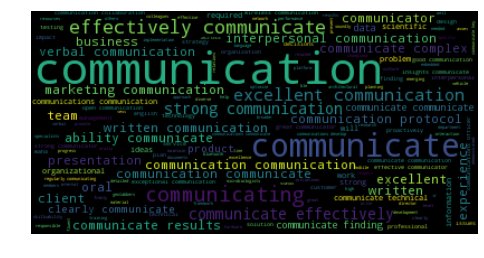

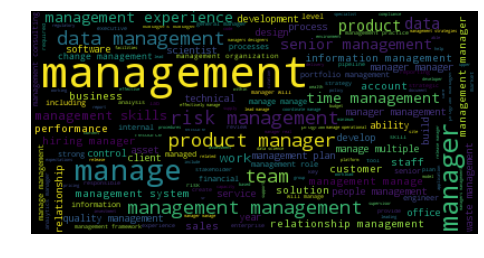

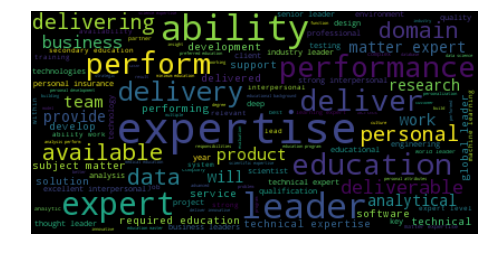

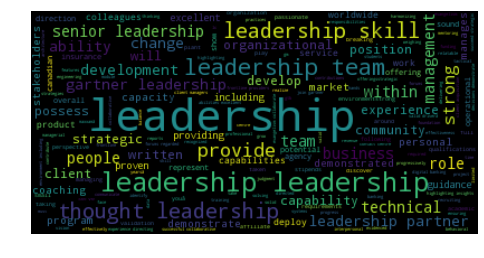

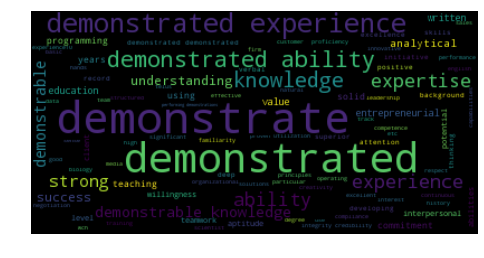

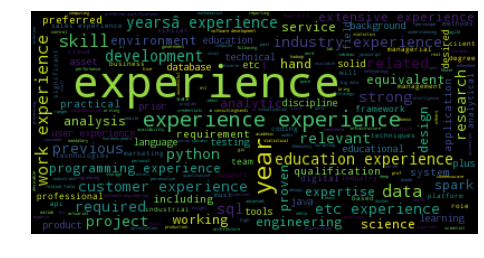

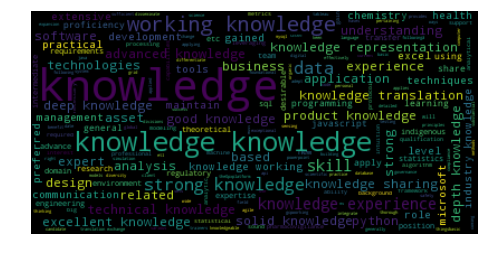

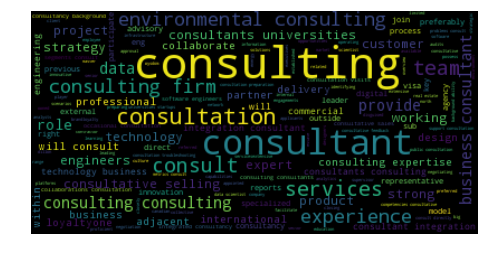

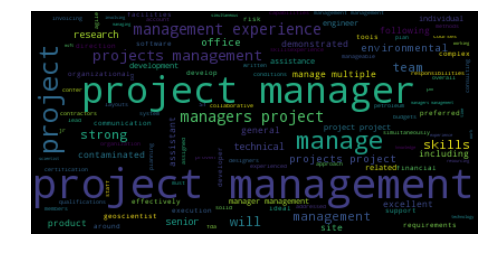

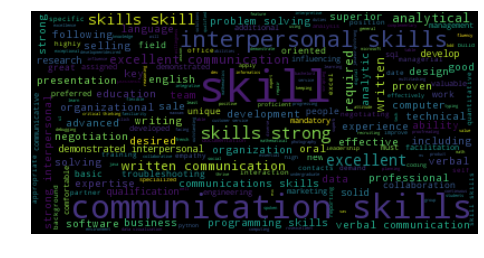

In [0]:
groups_of_cluster = skills.groupby('cluster')
for cluster, group in groups_of_cluster:
    word_cloud(group, 'feature')

From the above, it is easy to assign each cluster a unique topic. For instance, cluster number one is about 'Communication Skills' and two is about 'Management'. In this way, we are able to name each cluster as given below.

In [0]:
skills.sort_values('cluster', inplace = True)
skills.to_csv('/content/drive/My Drive/Colab Notebooks/nt_clusters.csv', encoding = 'utf-8')
nt_cluster_type = {}
nt_cluster_type[0] = 'Communication Skills'
nt_cluster_type[1] = 'Management'
nt_cluster_type[2] = 'Expertise'
nt_cluster_type[3] = 'Leadership'
nt_cluster_type[4] = 'Demonstration'
nt_cluster_type[5] = 'Experience'
nt_cluster_type[6] = 'Knowledge'
nt_cluster_type[7] = 'Consulting'
nt_cluster_type[8] = 'Project Management'
nt_cluster_type[9] = 'Skills'

CT = pd.DataFrame.from_dict(nt_cluster_type, orient='index')
CT = CT.reset_index()
CT.columns = ['cluster','description']
CT.to_csv('/content/drive/My Drive/Colab Notebooks/NT_cluster_descriptions.csv', encoding = 'utf-8')

Let us visualise the cluster densities i.e. the number of features per cluster.

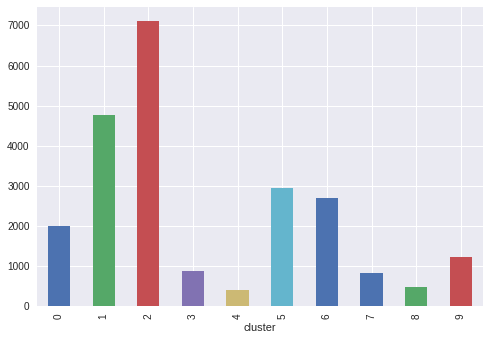

In [0]:
skills = pd.read_csv('/content/drive/My Drive/Colab Notebooks/nt_clusters.csv')
group_by_cluster = skills.groupby('cluster')
group_by_cluster.cluster.value_counts().reset_index(level=0, drop=True).plot.bar()

As we can see the clusters are not evenly split and we expect this with K-means clustering. Cluster 'Expertise' has maximum density while cluster 'Demonstration' has the least density.

We now repeat the same steps for the technical skills as well.

In [0]:
skills = pd.read_csv('/content/drive/My Drive/Colab Notebooks/candidate_t_features.tsv')
vectorizer = StemmedCountVectorizer(min_df=10, max_df=0.5,stop_words = stop_words)
vectorized = vectorizer.fit_transform(skills.feature)
num_clusters = 10
km = KMeans(n_clusters = num_clusters, init = 'k-means++', n_init = 1,verbose=1)
clustered = km.fit(vectorized)
predict = km.predict(vectorized)
assert len(predict) == vectorized.shape[0]
assert len(predict) == len(skills.feature)
skills['cluster'] = predict
skills.head(10)

Initialization complete
Iteration  0, inertia 71891.000
Iteration  1, inertia 52611.891
Iteration  2, inertia 52033.631
Iteration  3, inertia 52023.015
Iteration  4, inertia 52021.252
Iteration  5, inertia 52020.678
Iteration  6, inertia 52020.607
Iteration  7, inertia 52020.597
Iteration  8, inertia 52020.589
Iteration  9, inertia 52020.563
Iteration 10, inertia 52020.421
Iteration 11, inertia 52019.125
Iteration 12, inertia 52018.878
Iteration 13, inertia 52018.856
Converged at iteration 13: center shift 0.000000e+00 within tolerance 2.781997e-07


feature  cluster
0            design and        6
1        development of        8
2      machine learning        5
3       and development        8
4          knowledge of        9
5  software development        8
6      computer science        2
7   in computer science        2
8       the development        8
9     development teams        8

Once again, each technical feature has been mapped to a particular cluster now. We plot the word clouds again to get an idea of what each cluster represents.

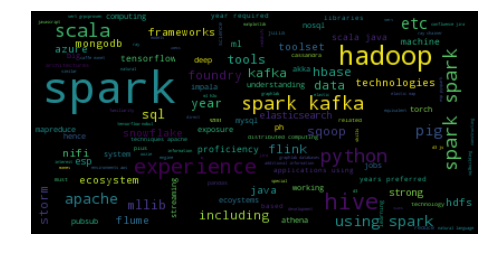

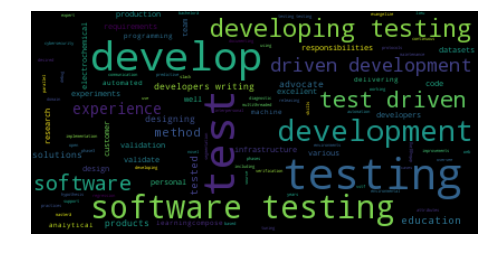

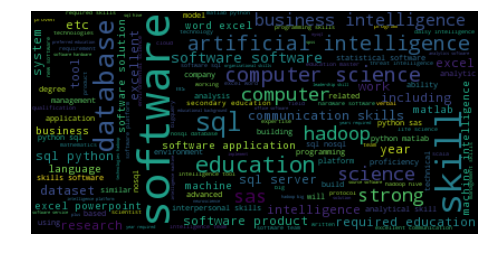

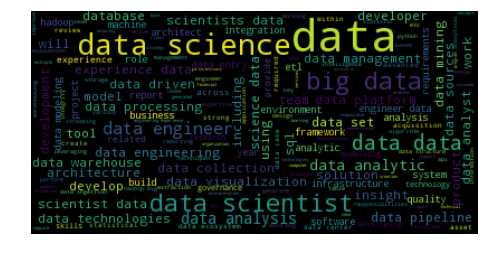

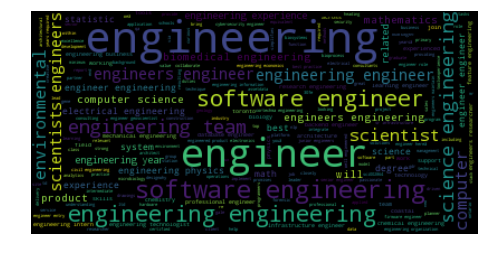

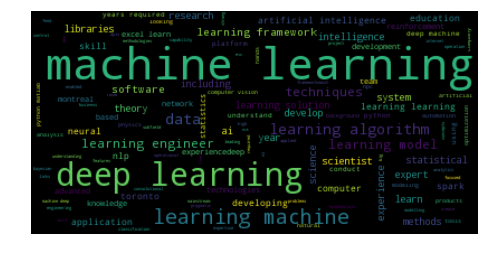

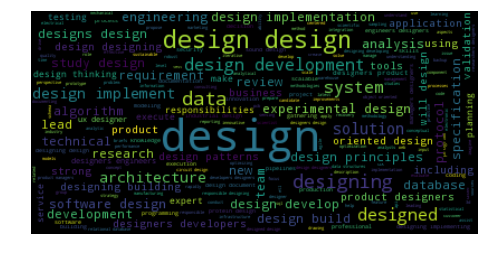

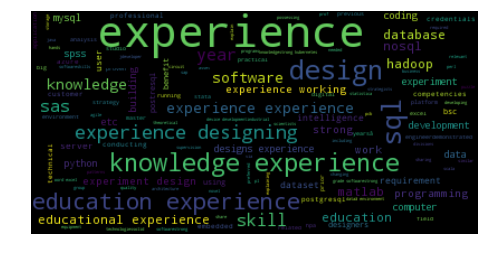

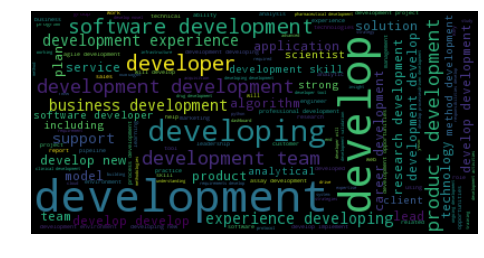

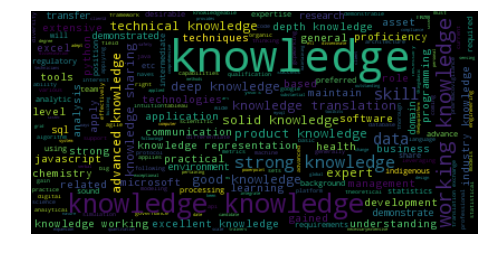

In [0]:
groups_of_cluster = skills.groupby('cluster')
for cluster, group in groups_of_cluster:
    word_cloud(group, 'feature')

Based on the word clouds, we name the clusters to give them more meaning. In this case, cluster number one would be 'Spark and Hadoop' and cluster number two would be 'Development and Testing' and so on.

In [0]:
skills.sort_values('cluster', inplace = True)
skills.to_csv('/content/drive/My Drive/Colab Notebooks/t_clusters.csv', encoding = 'utf-8')
t_cluster_type = {}
t_cluster_type[0] = 'Spark and Hadoop'
t_cluster_type[1] = 'Development and Testing'
t_cluster_type[2] = 'Software and Databases'
t_cluster_type[3] = 'Data Science'
t_cluster_type[4] = 'Engineering'
t_cluster_type[5] = 'Machine Learning and Deep Learning'
t_cluster_type[6] = 'Design'
t_cluster_type[7] = 'Experience'
t_cluster_type[8] = 'Development'
t_cluster_type[9] = 'Knowledge'

CT = pd.DataFrame.from_dict(t_cluster_type, orient='index')
CT = CT.reset_index()
CT.columns = ['cluster','description']
CT.to_csv('/content/drive/My Drive/Colab Notebooks/T_cluster_descriptions.csv', encoding = 'utf-8')

Once again, let us visualise the cluster densities for technical clusters.

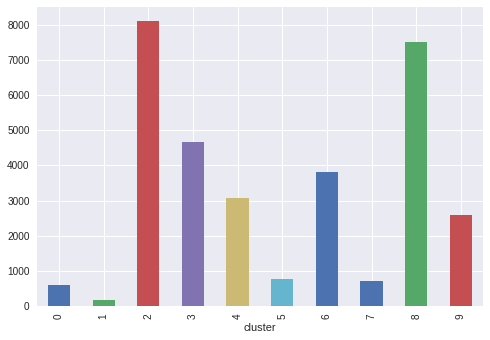

In [0]:
skills = pd.read_csv('/content/drive/My Drive/Colab Notebooks/t_clusters.csv')
group_by_cluster = skills.groupby('cluster')
group_by_cluster.cluster.value_counts().reset_index(level=0, drop=True).plot.bar()

In this case, cluster 'Software and Databases' has most features and cluster 'Development and Testing' has the least.

###5) Topic Modelling and LDA
Before we use the clusters we have just created, let us try another approach to cluster our documents into separate "topics". We will make use of topic-modelling and in specific, Latent Dirichlet Allocation to get an idea of how each document is distributed over topics and how each topic itself is a distribution over the words.

In [0]:
def lda_analysis():
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv', encoding = 'ISO-8859-1')
    postings = df['Job_Description'].values.tolist()
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = text.ENGLISH_STOP_WORDS
    p_stemmer = PorterStemmer()
    texts = []
    for posting in postings:
        raw = posting.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=200)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
    with open('/content/drive/My Drive/Colab Notebooks/ldamodel.pickle', 'wb') as fp:
        pickle.dump(ldamodel, fp)
    return vis
        
        
vis = lda_analysis()
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      21.133162        1       1 -0.044098  0.111339
5      16.167681        1       2 -0.079809  0.039651
7      13.020888        1       3 -0.132687  0.070478
4      12.300878        1       4 -0.157278 -0.022739
9       8.156201        1       5 -0.063056  0.118446
2       7.130373        1       6 -0.008015 -0.132111
3       6.616374        1       7  0.223255  0.049871
8       6.205233        1       8 -0.019803 -0.285555
6       5.473920        1       9  0.207159 -0.002197
0       3.795294        1      10  0.074332  0.052816, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
53    Default  4591.000000        data  4591.000000  30.0000  30.0000
415   Default  2597.000000    research  2597.000000  29.0000  29.0000
141   Default  3415.000000       manag  3415.000000  28.0000  28.0000
316   Default  2800.000000      design  2800.000000  27.0000  27.0000
227   Default  2142.000000      servic  2142.000000  26.0000  26.0000
5687  Default  1113.000000       danah  1113.000000  25.0000  25.0000
276   Default  2112.000000        year  2112.000000  24.0000  24.0000
62    Default  6144.000000     develop  6144.000000  23.0000  23.0000
209   Default  2411.000000      requir  2411.000000  22.0000  22.0000
30    Default  2781.000000        busi  2781.000000  21.0000  21.0000
89    Default  5988.000000      experi  5988.000000  20.0000  20.0000
5696  Default   972.000000       sciex   972.000000  19.0000  19.0000
425   Default  2568.000000     softwar  2568.000000  18.0000  18.0000
541   Default   549.000000       centr   549.000000  17.0000  17.0000
126   Default  1655.000000       learn  1655.000000  16.0000  16.0000
5064  Default   600.000000           ï   600.000000  15.0000  15.0000
274   Default  4959.000000        work  4959.000000  14.0000  14.0000
29    Default  1566.000000       build  1566.000000  13.0000  13.0000
3264  Default   579.000000         ice   579.000000  12.0000  12.0000
501   Default  1014.000000    platform  1014.000000  11.0000  11.0000
139   Default   795.000000      machin   795.000000  10.0000  10.0000
50    Default  1476.000000      custom  1476.000000   9.0000   9.0000
519   Default   446.000000     univers   446.000000   8.0000   8.0000
111   Default   719.000000     insight   719.000000   7.0000   7.0000
1005  Default   532.000000         web   532.000000   6.0000   6.0000
455   Default   523.000000          ai   523.000000   5.0000   5.0000
408   Default   690.000000        real   690.000000   4.0000   4.0000
80    Default  1708.000000       engin  1708.000000   3.0000   3.0000
1     Default  1763.000000        abil  1763.000000   2.0000   2.0000
374   Default  1628.000000        lead  1628.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2506  Topic10    67.809753     mainten   107.908691   2.8068  -5.4631
557   Topic10   112.520424        grow   276.285919   2.3731  -4.9566
2750  Topic10    33.547920         usa    36.540245   3.1860  -6.1668
1099  Topic10    66.466835       built   116.478958   2.7104  -5.4831
6     Topic10    69.331917     address   141.518692   2.5579  -5.4409
148   Topic10    68.744934        mean   140.534668   2.5564  -5.4494
43    Topic10   179.283783      comput   909.313232   1.6477  -4.4908
1601  Topic10    38.400322    montreal    47.088310   3.0674  -6.0317
297   Topic10   147.477478      career   782.145935   1.6030  -4.6861
374   Topic10   205.607651        lead  1628.911255   1.2017  -4.3538
31    Topic10   130.577652      candid   742.718506   1.5331  -4.8078
289   Topic10   137.466293        best   899.754150   1.3927  -4.7564
274   Topic10   276.561157        work  4959.576660   0.3848  -4.0573
442   Topic10    67.741562   transform   183.224670   2.2764  -5.4641
191   Topic10   100

As we can see above, the LDA has also managed to cluster the documents into ten topics. However, note that in this case, we don't split the features into technical and non-technical. We just give the LDA model the document set and let it work its magic. 

Let me run through the visualisation of the topics and the terms given above. On the left, each circle represents a separate topic and as we hover over each topic circle, the term distribution for that particular topic gets highlighted in red on the right side. On the right, the blue bar represents the overall term frequency and the red bar represents the term frequency within the highlighted topic.

However we will not proceed to use this LDA model and will just use it as a visualisation tool to show that clustering can be achieved in this way as well. In this case, the clusters are the topics and the features are the terms. This is because it is difficult to name the topics in this case as we have done in the clustering case and also more importantly, our topic modelling is not very efficient in this case. Ideally, we expect the topic circles to be more spread out, with fewer overlaps and covering all four quadrants. In our case, we find there is a lot of overlap and the topics are concentrated in mostly the first and second quadrant. For these reasons, we will not procees to use LDA for our application, but at the same time, taking nothing away from the power of topic modelling and the variety of problems that it can solve.

###6) Vector Space Model 
Let us now use the technical and non-technical clusters we created to give us more information about each of the job postings. Given a job description, we want to find the closest technical cluster and the closest non-technical cluster so that we can make inferences such as 'Job 1 needs you to be skilled in management and machine learning'. For this task, we will make use of TFIDF vectors to find the similarity between each cluster and a document and go on to find the most similar technical cluster and non-technical cluster for a document as well.

Let us start by creating the documents for each cluster.

In [0]:
def create_cluster_docs(df, filename):
    group_by_cluster = df.groupby('cluster')
    final_set_of_cluster_docs = {}
    document = ''
    for cluster, group in group_by_cluster:
        features = group['feature'].values
        for feat in features:
            document += feat
            document += ' '
        final_set_of_cluster_docs[cluster] = document
        document = ''
    with open(filename, 'wb') as fp:
        pickle.dump(final_set_of_cluster_docs, fp)


df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/nt_clusters.csv')
create_cluster_docs(df, '/content/drive/My Drive/Colab Notebooks/cluster_docs_nt.pickle')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/t_clusters.csv')
create_cluster_docs(df, '/content/drive/My Drive/Colab Notebooks/cluster_docs_t.pickle')

Now we will find the TFIDF vectors for all our documents. Documents in this case means all the job descriptions followed by the cluster documents we just created. For this we will make use of scikit-learn's TfidfVectorizer along with a stemmer.

In [0]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()	
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
    
    
def create_tfidf_vectors():
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv', encoding = 'ISO-8859-1')
    docs = df['Job_Description'].values.tolist()
    nt_cluster_docs = {}
    t_cluster_docs = {}
    with open('/content/drive/My Drive/Colab Notebooks/cluster_docs_nt.pickle', 'rb') as fp:
        nt_cluster_docs = pickle.load(fp)
    for cluster, doc in nt_cluster_docs.items():
        docs.append(doc)
    with open('/content/drive/My Drive/Colab Notebooks/cluster_docs_t.pickle', 'rb') as fp:
        t_cluster_docs = pickle.load(fp)
    for cluster, doc in t_cluster_docs.items():
        docs.append(doc)
    stop_words = ['available','availability']               
    stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)
    vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5, stop_words = stop_words)
    vectorized = vectorizer.fit_transform(docs)
    cluster_doc_vectors = vectorized[-20:]
    posting_doc_vectors = vectorized[:-20]
    t_cluster_docs = cluster_doc_vectors[-10:]
    nt_cluster_docs = cluster_doc_vectors[:10]
    with open('/content/drive/My Drive/Colab Notebooks/postings_tfidf.pickle', 'wb') as fp:
        pickle.dump(posting_doc_vectors, fp)
    with open('/content/drive/My Drive/Colab Notebooks/t_clusters_tfidf.pickle', 'wb') as fp:
        pickle.dump(t_cluster_docs, fp)
    with open('/content/drive/My Drive/Colab Notebooks/nt_clusters_tfidf.pickle', 'wb') as fp:
        pickle.dump(nt_cluster_docs, fp)
        
create_tfidf_vectors()

We move on to finding the similarities between each cluster and document. For this we will use the cosine similarity metric. 

In [0]:
def get_similarities():
    postings_vectors = None
    nt_vectors = None
    t_vectors = None
    with open('/content/drive/My Drive/Colab Notebooks/postings_tfidf.pickle', 'rb') as fp:
        postings_vectors = pickle.load(fp)
    with open('/content/drive/My Drive/Colab Notebooks/nt_clusters_tfidf.pickle', 'rb') as fp:
        nt_vectors = pickle.load(fp)
    with open('/content/drive/My Drive/Colab Notebooks/t_clusters_tfidf.pickle', 'rb') as fp:
        t_vectors = pickle.load(fp)
    final_scores = []
    for document in postings_vectors:
        nt_scores = {}
        t_scores = {}
        i = 0
        for nt_doc in nt_vectors:
            nt_scores[i] = cosine_similarity(document, nt_doc)
            i = i + 1
        i = 0
        for t_doc in t_vectors:
            t_scores[i] = cosine_similarity(document, t_doc)
            i = i + 1
        scores = [nt_scores, t_scores]
        final_scores.append(scores)
    with open('/content/drive/My Drive/Colab Notebooks/similarity_scores.pickle', 'wb') as fp:
        pickle.dump(final_scores, fp)
        
get_similarities()

Finally, we find the best possible technical cluster and non-technical cluster for each document. Here, "best" means most similar.

In [0]:
def get_best_buckets():
    final_scores = []
    y = []
    with open('/content/drive/My Drive/Colab Notebooks/similarity_scores.pickle', 'rb') as fp:
        final_scores = pickle.load(fp)
    for scores in final_scores:
        nt_scores = scores[0]
        t_scores = scores[1]
        nt_cluster = max(nt_scores.items(), key=operator.itemgetter(1))[0]
        t_cluster = max(t_scores.items(), key=operator.itemgetter(1))[0]
        y.append([nt_cluster, t_cluster])
    with open('/content/drive/My Drive/Colab Notebooks/best_buckets.pickle', 'wb') as fp:
        pickle.dump(y, fp)
        
        
get_best_buckets()

Now let us visualise our results. The following function takes in a random document number from 0 to 1001 (there are 1002 documents in the collection) and plots a graph of similarity scores for all the clusters. There are two separate graphs, one for technical clusters and one for non-technical clusters.

In [0]:
def plot_similarity_graph(doc_number):
  final_scores = []
  with open('/content/drive/My Drive/Colab Notebooks/similarity_scores.pickle', 'rb') as fp:
        final_scores = pickle.load(fp)
  doc_scores = final_scores[doc_number]
  nt_scores = doc_scores[0]
  t_scores = doc_scores[1]
  nt_score_list = []
  t_score_list = []
  for cluster, score in nt_scores.items():
    nt_score_list.append(score.item())
  for cluster, score in t_scores.items():
    t_score_list.append(score.item())
  nt_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NT_cluster_descriptions.csv')
  nt_cluster_names = nt_df['description'].values.tolist()
  t_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/T_cluster_descriptions.csv')
  t_cluster_names = t_df['description'].values.tolist()
  nt_dict = {'Clusters':nt_cluster_names, 'Similarities':nt_score_list}
  t_dict = {'Clusters':t_cluster_names, 'Similarities':t_score_list}
  df_nt = pd.DataFrame(nt_dict)
  df_t = pd.DataFrame(t_dict)
  df_nt.plot.bar(x = 'Clusters', y = 'Similarities', title = 'Non-technical skills')
  df_t.plot.bar(x = 'Clusters', y = 'Similarities', title = 'Technical Skills')
  


Let us test our function on a random document, say document number 500.

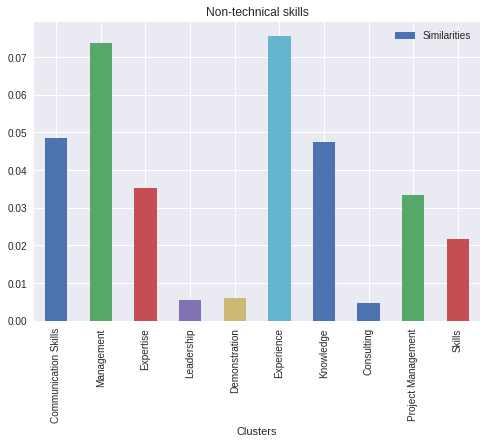

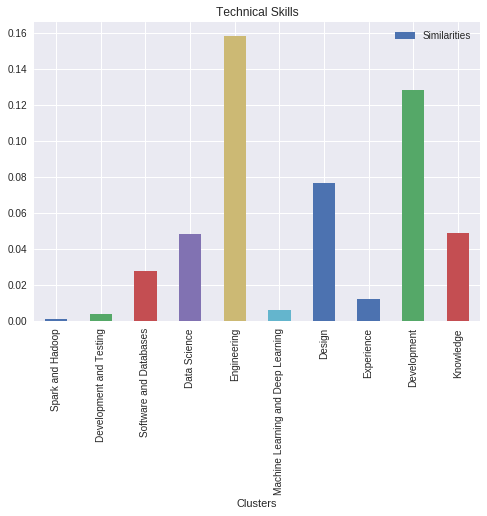

In [0]:
doc_number = 500
plot_similarity_graph(doc_number)

From the above plots, it is quite obvious that for job number 500, Engineering skills and Experience are major factors that are sought after from the job description. Management is a very important factor as well. Consulting and Leadership are skills that are not sought after. Similarly, for the technical skills, Spark and Hadoop and Machine Learning and Deep Learning are not important factors while Deveopment and design are quite important factors as well. In this manner, a job applicant can assess the job requirements and evaluate his/her profile.

Let us try another one. This time, job number 175.

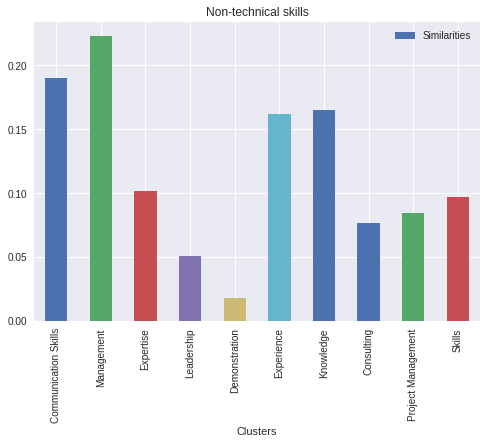

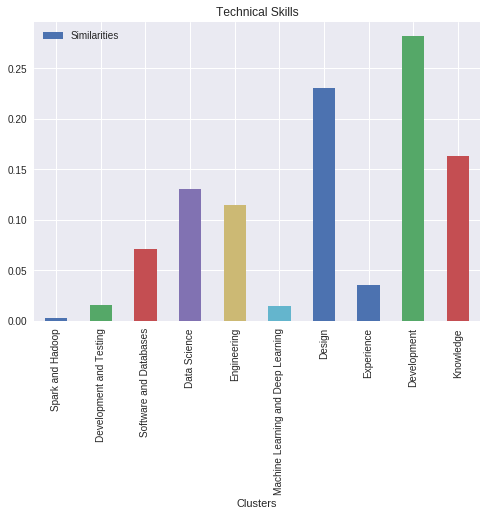

In [0]:
doc_number = 175
plot_similarity_graph(doc_number)

So job number 175 expects good management skills and good development skills as well. In this way, for each job, we can infer the requirements in terms of the clusters we formed previously.

###7) Self Organizing Maps
Let us now use Self Organizing Maps (SOMs) to visualise how close each company is to each other purely based on their job descriptions. This will give job seekers an idea of which companies are offering similar jobs and they can choose which companies they would like to apply to. SOMs are neural networks that are used for dimension reduction. In this case, we are reducing the dimensions of the input which is the TFIDF vector input for each document to two dimensions to aid visualisation. However because of the very close clustering, the map is not extremely clear.  The different colours indicate the different technical clusters. The colour codes are as follows:

###Blue: Spark and Hadoop
###Green: Development and Testing
###Red: Software and Databases
###Cyan: Data Science
###Magenta: Engineering
###Yellow: Machine Learning and Deep learning
###Black: Design
###White: Experience
###Indigo: Development
###Dim gray: Knowledge


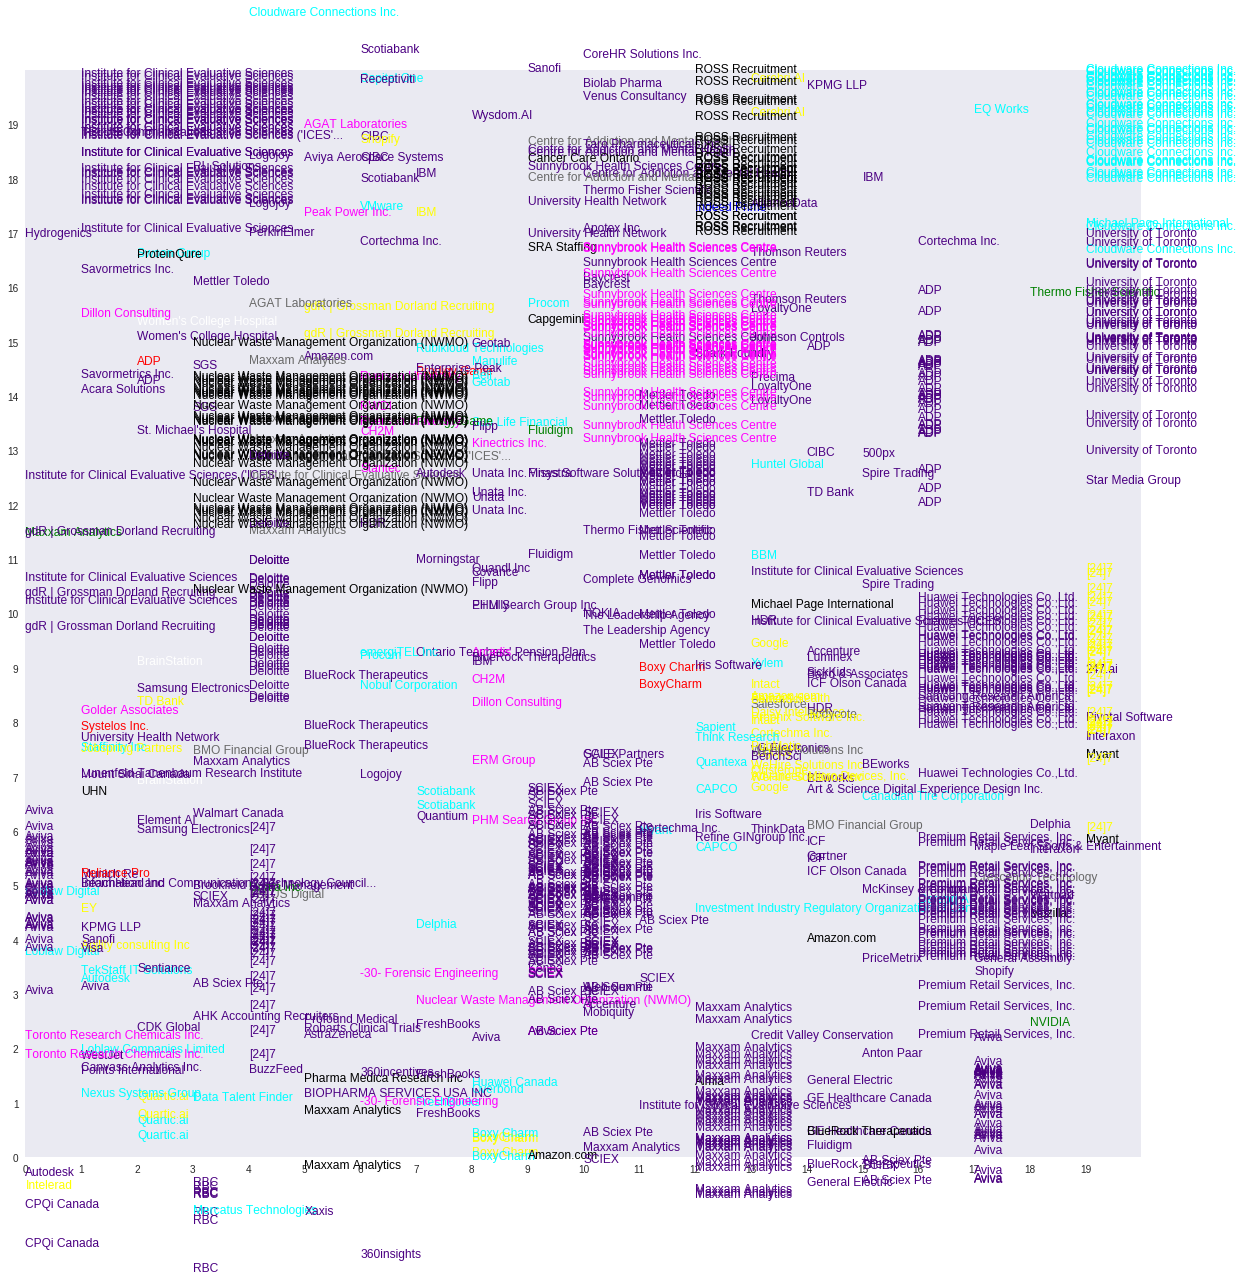

In [0]:
def som_visualisation():
    X = None
    y = None
    with open('/content/drive/My Drive/Colab Notebooks/postings_tfidf.pickle', 'rb') as fp:
        X = pickle.load(fp)
    with open('/content/drive/My Drive/Colab Notebooks/best_buckets.pickle', 'rb') as fp:
        y = pickle.load(fp)
    best_t_scores = []
    for pair in y:
        best_t_scores.append(pair[1])
    nb_features = X.shape[1]
    X = X.toarray()
    som = MiniSom(x  = 20, y = 20, input_len = nb_features, sigma = 1.0, learning_rate = 0.5)
    som.random_weights_init(X)
    som.train_random(X, num_iteration = 300)
    bucket_to_color = {0:'blue', 
                       1:'green',
                       2:'red',
                       3:'cyan',
                       4:'magenta',
                       5:'yellow',
                       6:'black',
                       7:'white',
                       8:'indigo',
                       9:'dimgray'}
    color = [bucket_to_color[i] for i in best_t_scores]
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Indeed_job_vacancies.csv', encoding = 'ISO-8859-1')
    titles = df['Company_Name'].values.tolist()
    plt.figure(figsize = (20, 20))
    for i,(t, c, x) in enumerate(zip(titles, color, X)):
        w = som.winner(x)
        plt.text(w[0], w[1] + np.random.randn()*0.9, t, color = c)
    plt.xticks(range(20))
    plt.yticks(range(20))
    plt.grid()
    plt.xlim([0, 20])
    plt.ylim([0, 20])
    plt.plot()
    plt.show()
    plt.close(1)
    
    
som_visualisation()

Although the map is not very clear, it gives us a lot of information about all the companies. For example, from the map we can infer that Boxy Charm and Amazon are offering similar jobs or perhaps that Maxxam Analytics and Toronto Research Chemicals are offering very different jobs. The fact that similar colour codes get clustered together often is an indication that our initial clustering was good.

###8) Text Classifier
We want to build a Naive Bayes classifier that will be able to classify future job postings into one of the clusters we have defined. Such a classifier is useful as we don't need to keep updating our TFIDF model as and when we see a new document. We assume that we have a good enough dataset that gives us a good variety of clusters as well i.e. we expect that any document in the future can safely be classified into any of these clusters - both technical and non-technoical. However, we lack training data and hence we use our TFIDF models to give the technical cluster label and non-technical cluster label for each job posting. Ideally, I would have liked to use a sequence learning model such as LSTMs for the classification task but there are just too few documents to make any conclusions with a deep learning model. 
Once our Naive Bayes model is trained, given a new job posting, we can find the technical cluster it belongs to and the non-technical cluster it belongs to.

The accuracy of the technical model is 78.43137254901961




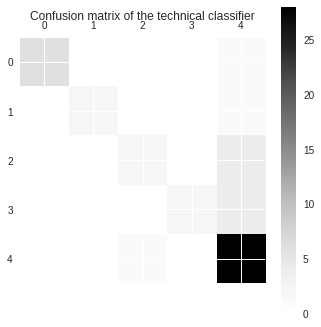



The accuracy of the nontechnical model is 82.35294117647058




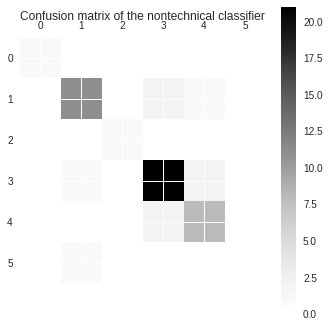

In [0]:
def build_training_data(model_type):
    X = None
    y = None
    with open('/content/drive/My Drive/Colab Notebooks/postings_tfidf.pickle', 'rb') as fp:
        X = pickle.load(fp)
    X = X.toarray()
    with open('/content/drive/My Drive/Colab Notebooks/best_buckets.pickle', 'rb') as fp:
        y = pickle.load(fp)
    y = np.array(y)
    y = np.transpose(y)
    if model_type == 'technical':
        y = y[1]
    else:
        y = y[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)
    return X_train, X_test, y_train, y_test
  
  
X_train, X_test, y_train, y_test = build_training_data('technical')
technical_model = MultinomialNB()
technical_model.fit(X_train, y_train)
technical_predictions = technical_model.predict(X_test)
with open('/content/drive/My Drive/Colab Notebooks/technical_model.pickle', 'wb') as fp:
  pickle.dump(technical_model,fp)
accuracy = accuracy_score(y_test, technical_predictions) * 100
print('The accuracy of the technical model is ' + str(accuracy))
print()
print()
cm = confusion_matrix(y_test, technical_predictions)
plt.matshow(cm)
plt.title('Confusion matrix of the technical classifier')
plt.colorbar()
plt.show()
plt.close(1)
print()
print()
X_train, X_test, y_train, y_test = build_training_data('nontechnical')
nontechnical_model = MultinomialNB()
nontechnical_model.fit(X_train, y_train)
nontechnical_predictions = nontechnical_model.predict(X_test)
with open('/content/drive/My Drive/Colab Notebooks/nontechnical_model.pickle', 'wb') as fp:
  pickle.dump(nontechnical_model,fp)
accuracy = accuracy_score(y_test, nontechnical_predictions) * 100
print('The accuracy of the nontechnical model is ' + str(accuracy))
print()
print()
cm = confusion_matrix(y_test, nontechnical_predictions)
plt.matshow(cm)
plt.title('Confusion matrix of the nontechnical classifier')
plt.colorbar()
plt.show()
plt.close(1)





The technical model has an accuracy of 78% and the nontechnical model an accuracy of 82%. These models can now be used to predict the categories of future job postings to determine what technical skills and non-technical skills are most important for that job.

###9) Designing a curriculum: Data Analytics and AI 

The course is designed for industry professionals who do not have a background in Data Science or AI but would like to take their first steps towards a career in these areas. We assume that they already have sufficient programming skills and a basic background in computer science.
We have kept in mind several details while planning this curriculum. For example, we have chosen SAS over SPSS due to its popularity we noted from one of our early visualisations. For similar reasons, we have chosen Python over R.
We noted the importance of Machine Learning and Deep Learning and have dedicated three out of the ten lectures to these topics. However, it goes without saying that even with three lectures, we will only be able to give a brief introduction to these topics and not deal with them in detail. We noted the importance of Software engineering for industry professionals and hence have a lecture dedicated to that as well. For similar reasons, databases, SQL,  Spark and Hadoop all find a slot in our curriculum.

###Lecture 1 - Introduction


*   Recognizing data analytics projects in business
*   Sources of data (Internet, sensors, etc.)
*   Types of data (numerical, ordinal, nominal, etc.)

###Lecture 2 - Mathematics Refreshers


*   Probability Refresher


  1.   Discrete distributions and their properties
  2.   Continuous distributions and their properties


*   Linear Algebra Refresher


1.   Matrices and their properties (rank, eigen values, eigen vectors, etc.)
2.   Matrix decomposition (diagonalization, SVD)

###Lecture 3 - Data Preprocessing


*   Preprocessing numerical data (feature scaling, imputing missing values, etc.)
*   Preprocessing text data (tokenization, lemmatization, stemming, etc.)
*   Preprocessing multimedia data (images, videos, audios)

###Lecture 4 - Machine Learning Part 1


*   Basic Linear Regression
*   Cost functions, Gradient Descent and Regularization
*   Logistic Regression
*   Evaluating the learning algorithm


1.   Evaluation metrics (understanding classification reports and confusion matrices, etc.)
2.   Bias, Variance and other learning curves
2.   Parameter tuning



###Lecture 5 - Machine Learning Part 2

*   Naive Bayes classifier 
*   Support Vector Machines
*   Decision Trees and Random Forests
*   K nearest neighbours
*   K-means clustering

###Lecture 6 - Introduction to Deep Learning

*   The neuron and the perceptron
*   Dense feed forward networks
*   Basics of Backpropagation
*   Regularization for deep learning (Early stopping, Dropout, etc.)
*   Other types of neural networks (CNN, RNN, Boltzmann machines, etc)

###Lecture 7 - Statistical Testing

*   Tests of significance (t-test, F-test, etc.)
*   Regression diagnostics
*   Introduction to SAS

###Lecture 8 - Big Data 

*   What is Big Data ?
*   Introduction to databases and SQL
*   Dimensionality reduction and PCA
*   Spark and Hadoop

###Lecture 9 - Important Python Packages

*   Numpy, Pandas and Matplotlib
*   Scikit-Learn
*   Keras

###Lecture 10 - Software Engineering for AI

*   Building models that are easily deployable
*   Continuous integration and version control
*   Software testing
*   API development





























